# GCC's ssc-cdi : tomography pipeline for Cateretê v0.1
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/
- #### To use a test sample:
    - dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/glass24/2023-05-12-15h19m_glass24.hdf5"

In [ ]:
import sscInstall, os
server = sscInstall.connect_server()
sscInstall.install_jupyter(server,beamline='caterete',sscCdi='0.4.16',sscPtycho='2.1.1',sscPimega='0.5.3',sscRaft='2.0.1',sscRadon='1.0.0',sscResolution='1.2.3'), os._exit(00) # shutdown kernel. Required to import new installed packages

## Imports

In [1]:
%matplotlib widget
import numpy as np, matplotlib.pyplot as plt
from sscCdi import read_data, define_paths, tomo_sort, tomo_crop, tomo_unwrap, tomo_equalize, preview_angle_projection, tomo_alignment, tomo_recon, tomo_equalize3D, deploy_visualizer, plot_histograms, clean_pwcdi_dataset

## Load dictionary

In [2]:
dic = {} # or load from template file

## Load data

In [3]:
dic["recon_method"]  = "ptycho" # ptycho or pwcdi
dic["contrast_type"] = "phase" # phase or magnitude
dic["sinogram_path"] = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass24/2023-05-12-15h19m_glass24.hdf5"
dic = define_paths(dic)

obj, angles = read_data(dic)
print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

Object shape = (60, 3481, 3481) 	 Number of angles: (60, 2)


In [4]:
deploy_visualizer(obj,title='Original sinogram',cmap='gray')

In [5]:
crop = obj[:,1600:-1400,1400:-1500]
deploy_visualizer(crop,title='Original sinogram',cmap='gray')

## Sort data

In [6]:
tomo_sort(dic,obj, angles)

Time elapsed: 2.55 s


In [7]:
deploy_visualizer(np.load(dic["ordered_object_filepath"]),title="Ordered sinogram",cmap='gray')

## Crop

In [8]:
dic["top_crop"]    = 1500
dic["bottom_crop"] = 1400
dic["left_crop"]   = 1400
dic["right_crop"]  = 1400
tomo_crop(dic)

Cropped sinogram shape: (60, 581, 681)
Time elapsed: 1.12 s


In [9]:
deploy_visualizer(np.load(dic["cropped_sinogram_filepath"]),title="Cropped sinogram",cmap='gray')

## Unwrap

In [10]:
dic["bad_frames_before_unwrap"] = []
tomo_unwrap(dic)

Using 32 parallel processes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 125.60it/s]

Time elapsed: 1.70 s


In [11]:
deploy_visualizer(np.load(dic["unwrapped_sinogram_filepath"]),title="Unwrapped sinogram",cmap='gray')

## 2D Equalization

In [24]:
dic["sinogram_to_equalize"] = 'unwrapped' # cropped or unwrapped
dic["bad_frames_before_equalization"] = []
dic["equalize_gradient"] = False
dic["equalize_global_offset"] = False
dic["equalize_invert"] = True
dic["equalize_local_offset"] = []
dic["equalize_outliers"] = 0

tomo_equalize(dic)

Sinogram shape to unwrap:  (60, 581, 681)
Using 32 parallel processes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 1386.49it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old  -1.1115834 -5.272718727588654 0.18058163 5.633881986141205 6.0498953
New  -1.4397715 -5.131946235895157 0.37690517 5.885756582021713 6.7427197
Time elapsed: 1.00 s


In [25]:
deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray')

In [27]:
deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto')#,limits=(0,0.5))

## Alignment

In [28]:
dic["wiggle_sinogram_selection"] = dic["equalized_sinogram_filepath"]
dic["step_percentage"] = 0 # need to project irregular angle steps to a regular grid?
preview_angle_projection(dic)

Simulating projection of angles to regular grid...
Before+after frames added: 75
Intermediate null frames : 243
                        + -----
Total null frames        : 318
Frames being used        : 60  of  60
                        + -----
Projected Angles         : 378


In [29]:
dic["CPUs"] = 32
dic["bad_frames_before_wiggle"] = [] 
dic["wiggle_reference_frame"] = 0
dic = tomo_alignment(dic)

ssc-radon: creating 378x581x681 shared arrays (tomogram)
ssc-radon: creating 378x581x681 shared arrays (tomogram)
	Finished vertical wiggle. Starting horizontal wiggle...
ssc-radon: creating 378x581x681 shared arrays (tomogram)
Time elapsed: 8.76 s


In [30]:
deploy_visualizer(np.load(dic["wiggle_sinogram_filepath"]),title="Aligned sinogram",cmap='gray',axis=1)

## Tomography

In [31]:
dic["GPUs"] = [0]
dic["tomo_algorithm"] = "EEM"
dic["tomo_iterations"] = 10
dic["tomo_regularization"] = False
dic["tomo_regularization_param"] = 0.001

recon3D = tomo_recon(dic)

	Starting regularization frame by frame...
	Regularization done!
Starting tomographic algorithm EEM with 10 iterations
EM param: 20 [10, 3, 8] 0.0001 1e-15 eEM 378 [0] 681 581
	Applying wiggle center-of-mass correction to 3D reconstructed slices...
ssc-radon: creating 581x681x681 shared arrays (tomogram)
	 Tomography done!
Saving tomography logfile...
	Saved!
Time elapsed: Tomography: 30.581700325012207 s


In [32]:
deploy_visualizer(np.load(dic["reconstruction_filepath"]),title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

## 3D Equalization

In [33]:
dic["tomo_remove_outliers"] = 0
dic["tomo_threshold"] = 15.0
dic["tomo_local_offset"] = []
dic["tomo_mask"] = []

tomo_equalize3D(dic)

Time elapsed: 5.77 s


In [34]:
deploy_visualizer(np.load(dic["eq_reconstruction_filepath"]),title="Equalized Recon",cmap='gray',axis=0)

Original data statistics:  
	Max = 1.12e+03
	 Min = -3.67e+02
	 Mean = 2.94e-02
	 StdDev = 1.98e-01
Thresholded data statistics:  
	Max = 1.50e+01
	 Min = -1.50e+01
	 Mean = 2.93e-02
	 StdDev = 1.04e-01


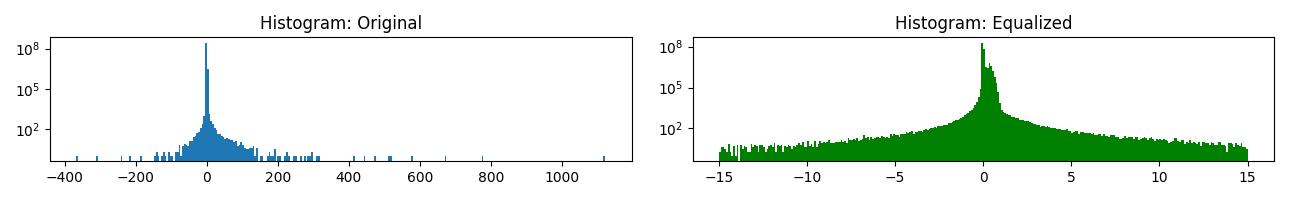

In [35]:
equalized_tomogram = np.load(dic["eq_reconstruction_filepath"])
plot_histograms(recon3D, equalized_tomogram,bins=300)